In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# EDA

In [2]:
df = pd.read_excel('/content/drive/MyDrive/sales.xlsx')

In [3]:
df

,year,quarter,sales
0,2015,1,244.450000
1,2015,2,1318.610000
2,2015,3,69.010000
3,2015,4,109.590000
4,2016,1,519.840000
5,2016,2,10648.280000
6,2016,3,390.820000
7,2016,4,10970.100000
8,2017,1,111721.278000
9,2017,2,185751.577000


In [4]:
df.describe()

,year,quarter,sales
count,24.000000,24.00000,24.000000
mean,2017.500000,2.50000,209849.631394
std,1.744557,1.14208,226138.327335
min,2015.000000,1.00000,69.010000
25%,2016.000000,1.75000,8315.862500
50%,2017.500000,2.50000,175458.658297
75%,2019.000000,3.25000,297202.885896
max,2020.000000,4.00000,885613.857366


line plot of sales v/s year

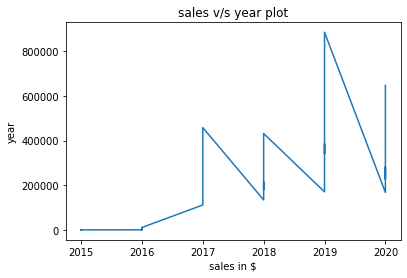

In [5]:
plt.plot(df['year'],df['sales'])
plt.xlabel('sales in $')
plt.ylabel('year')
plt.title('sales v/s year plot')
plt.show()

In [6]:
#filter out 'sales' column
series = df['sales']
series

0        244.450000
1       1318.610000
2         69.010000
3        109.590000
4        519.840000
5      10648.280000
6        390.820000
7      10970.100000
8     111721.278000
9     185751.577000
10    187791.443000
11    458570.924000
12    134335.873230
13    214062.475160
14    180409.238320
15    431796.553960
16    170508.078274
17    385837.940800
18    340634.529941
19    885613.857366
20    167752.671917
21    282725.671215
22    226828.323095
23    647780.018182
Name: sales, dtype: float64

# LSTM Data Preparation

# Step-1 : Transform the time series data so that it is stationary

> Stationary data is easier to model and will very likely result in more skillful forecasts.

> A standard way to remove a trend is by differencing the data. That is the observation from the previous time step (t-1) is subtracted from the current observation (t). This removes the trend and we are left with a difference series, or the changes to the observations from one time step to the next.

> Then we invert this process in order to take forecasts made on the differenced series back into their original scale.

In [7]:
# functionality to create a differenced data
def difference(df, interval=1):
	diff = list()
	for i in range(interval, len(df)):
		value = df[i] - df[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [8]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]


In [9]:
#calling the above functionality
raw_values = series.values
diff_values = difference(raw_values, 1)

In [10]:
diff_values

0       1074.160000
1      -1249.600000
2         40.580000
3        410.250000
4      10128.440000
5     -10257.460000
6      10579.280000
7     100751.178000
8      74030.299000
9       2039.866000
10    270779.481000
11   -324235.050770
12     79726.601930
13    -33653.236840
14    251387.315640
15   -261288.475686
16    215329.862526
17    -45203.410859
18    544979.327425
19   -717861.185449
20    114972.999298
21    -55897.348120
22    420951.695087
dtype: float64

# Step - 2: Transform the time series into a supervised learning problem

> For a time series problem, we use observation at time step 't-1' as current input and observation at time step 't' as current output. The same is implemented using below functionality

In [11]:
# functionality to frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
  
  df=pd.DataFrame(data)
  #shifting column values by a lag=1
  columns = [df.shift(i) for i in range(1, lag+1)]
  #append shifted values to df
  columns.append(df)
  
  #concatenate both of them
  df = pd.concat(columns, axis=1)

  #fill the NaN at the first entry with zero  
  df.fillna(0, inplace=True)

  return df


In [12]:
#calling the above functionality
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [13]:
supervised_values

array([[ 0.00000000e+00,  1.07416000e+03],
       [ 1.07416000e+03, -1.24960000e+03],
       [-1.24960000e+03,  4.05800000e+01],
       [ 4.05800000e+01,  4.10250000e+02],
       [ 4.10250000e+02,  1.01284400e+04],
       [ 1.01284400e+04, -1.02574600e+04],
       [-1.02574600e+04,  1.05792800e+04],
       [ 1.05792800e+04,  1.00751178e+05],
       [ 1.00751178e+05,  7.40302990e+04],
       [ 7.40302990e+04,  2.03986600e+03],
       [ 2.03986600e+03,  2.70779481e+05],
       [ 2.70779481e+05, -3.24235051e+05],
       [-3.24235051e+05,  7.97266019e+04],
       [ 7.97266019e+04, -3.36532368e+04],
       [-3.36532368e+04,  2.51387316e+05],
       [ 2.51387316e+05, -2.61288476e+05],
       [-2.61288476e+05,  2.15329863e+05],
       [ 2.15329863e+05, -4.52034109e+04],
       [-4.52034109e+04,  5.44979327e+05],
       [ 5.44979327e+05, -7.17861185e+05],
       [-7.17861185e+05,  1.14972999e+05],
       [ 1.14972999e+05, -5.58973481e+04],
       [-5.58973481e+04,  4.20951695e+05]])

###  Split data into training and testing sets

qaurters of year 2020 are taken as test set and before that are taken as training sets

In [14]:
train, test = supervised_values[0:20], supervised_values[20:]

In [15]:
train

array([[ 0.00000000e+00,  1.07416000e+03],
       [ 1.07416000e+03, -1.24960000e+03],
       [-1.24960000e+03,  4.05800000e+01],
       [ 4.05800000e+01,  4.10250000e+02],
       [ 4.10250000e+02,  1.01284400e+04],
       [ 1.01284400e+04, -1.02574600e+04],
       [-1.02574600e+04,  1.05792800e+04],
       [ 1.05792800e+04,  1.00751178e+05],
       [ 1.00751178e+05,  7.40302990e+04],
       [ 7.40302990e+04,  2.03986600e+03],
       [ 2.03986600e+03,  2.70779481e+05],
       [ 2.70779481e+05, -3.24235051e+05],
       [-3.24235051e+05,  7.97266019e+04],
       [ 7.97266019e+04, -3.36532368e+04],
       [-3.36532368e+04,  2.51387316e+05],
       [ 2.51387316e+05, -2.61288476e+05],
       [-2.61288476e+05,  2.15329863e+05],
       [ 2.15329863e+05, -4.52034109e+04],
       [-4.52034109e+04,  5.44979327e+05],
       [ 5.44979327e+05, -7.17861185e+05]])

In [16]:
test

array([[-717861.185449,  114972.999298],
       [ 114972.999298,  -55897.34812 ],
       [ -55897.34812 ,  420951.695087]])

# Step-3 : Transform the observations to have a specific scale

> We can transform the dataset to the range [-1, 1] using the MinMaxScaler class.

> Then, we must invert the scale on forecasts to return the values back to the original scale so that the results can be interpreted and a comparable error score can be calculated.

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

In [19]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 

In [20]:
#calling above functionality
scaler, train_scaled, test_scaled = scale(train, test)

In [21]:
train_scaled

array([[-0.25395838,  0.13860038],
       [-0.25148682,  0.13492017],
       [-0.25683362,  0.13696347],
       [-0.25386501,  0.13754893],
       [-0.25301443,  0.15293993],
       [-0.23065357,  0.12065414],
       [-0.27756006,  0.15365394],
       [-0.22961622,  0.29646199],
       [-0.02213714,  0.2541433 ],
       [-0.08361997,  0.1401298 ],
       [-0.2492648 ,  0.56574113],
       [ 0.3690858 , -0.37660198],
       [-1.        ,  0.26316471],
       [-0.07051318,  0.08360152],
       [-0.33139207,  0.53502915],
       [ 0.32446582, -0.27691153],
       [-0.85516444,  0.47792384],
       [ 0.2415002 ,  0.06530915],
       [-0.35796819,  1.        ],
       [ 1.        , -1.        ]])

In [22]:
test_scaled

array([[-1.90570553,  0.31898554],
       [ 0.01058625,  0.04837282],
       [-0.38257417,  0.80357356]])

# Building LSTM model

In [23]:
from keras.models import Sequential
from keras.layers import *

In [24]:
X, y = train_scaled[:,0:-1], train_scaled[:,-1]

In [25]:
X.shape

(20, 1)

In [26]:
X = X.reshape(X.shape[0], 1, X.shape[1])

In [27]:
X.shape

(20, 1, 1)

In [28]:
model = Sequential()
model.add(LSTM(units=4, batch_input_shape = (1, X.shape[1], X.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 4)                    96        
_________________________________________________________________
dense (Dense)                (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [29]:
hist = model.fit(X, y, epochs=100, batch_size=1, verbose=0, shuffle=False)

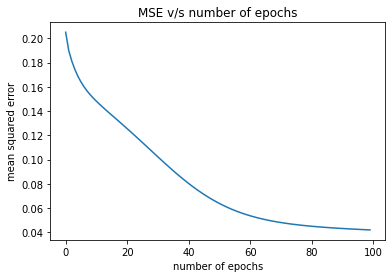

In [30]:
# plot metrics
plt.plot(hist.history['mse'])
plt.xlabel('number of epochs')
plt.ylabel('mean squared error')
plt.title('MSE v/s number of epochs')
plt.show()

In [31]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
model.predict(train_reshaped, batch_size=1)

array([[ 0.22225425],
       [ 0.32297093],
       [ 0.31302395],
       [ 0.29202455],
       [ 0.28057078],
       [ 0.25514668],
       [ 0.29372552],
       [ 0.24673809],
       [ 0.05873302],
       [ 0.15278158],
       [ 0.28671324],
       [-0.31953102],
       [ 0.50769186],
       [ 0.17711775],
       [ 0.36266547],
       [-0.2916252 ],
       [ 0.51903373],
       [-0.16445337],
       [ 0.38978344],
       [-0.8230306 ]], dtype=float32)

In [32]:
# functionality to make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [33]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=305312.185821, Expected=282725.671215
Month=2, Predicted=272477.381333, Expected=226828.323095
Month=3, Predicted=408735.929793, Expected=647780.018182


# Model Evaluation

Test RMSE: 141109.961


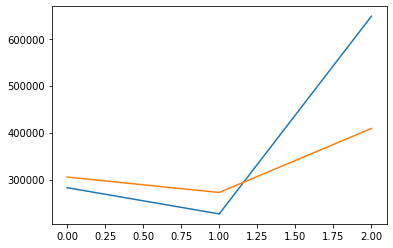

In [34]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(raw_values[-3:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
#blue line is raw_values
plt.plot(raw_values[-3:])
#red one is predictions
plt.plot(predictions)
plt.show()